In [1]:
import numpy as np
import scipy.integrate as integrate
import pydelfi.ndes as ndes
from pydelfi import delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
import h5py
import tqdm
from astropy.cosmology import Planck15, z_at_value, FlatwCDM
import astropy.units as u
from scipy.integrate import cumtrapz
from scipy.interpolate import RectBivariateSpline, interp1d
from true_params import true_params, uncert, ifo
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
with h5py.File('/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/thetas.h5', 'r') as f:
    thetas = np.array(f['Theta'])
thetas = np.sort(np.concatenate((thetas, [0,1])))
ticum = interp1d(np.linspace(0, 1, len(thetas)), thetas)

with h5py.File('/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/optimal_snr.h5', 'r') as f:
    ms = np.array(f['ms'])
    rhos = np.array(f['SNR'])
oint = RectBivariateSpline(ms, ms, rhos)

In [3]:
def optimal_snr(m1obs, m2obs, dl):
    return oint.ev(m1obs, m2obs)/dl

zMax = 2 # determined based on making sure the observed redshift distribution tails off completely
z = np.expm1(np.linspace(np.log(1), np.log(zMax+1), 1000))

# # Use this for fix distribution
# cosm = FlatwCDM(Planck15.H0.value, Planck15.Om0, -1.0)
# dNdz = 4.0*np.pi*true_params['R0']*(1+z)**(true_params['gamma']-1)*cosm.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value

# Nperyear = np.trapz(dNdz, z)
# Nz = cumtrapz(dNdz, z, initial=0)

# z_icdf = interp1d(Nz/Nperyear, z)

def event(h0, omegam, om, z):
# # Use this for parameter dependent distribution
    cosm = FlatwCDM(h0, omegam, om)
    dNdz = 4.0*np.pi*true_params['R0']*(1+z)**(true_params['gamma']-1)*cosm.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value

    Nperyear = np.trapz(dNdz, z)
    Nz = cumtrapz(dNdz, z, initial=0)

    z_icdf = interp1d(Nz/Nperyear, z)

    return Nperyear, Nz, z_icdf

mmin = true_params['MMin']
mmax = true_params['MMax']

def draw_pl(x0, x1, alpha):
    r = np.random.rand()
    opa = 1+alpha
    return (x0**opa*(1-r) + x1**opa*r)**(1/opa)

def draw_truth(z_icdf, N):
    m2 = np.linspace(1.0,1.0,N)
    m1 = np.linspace(0.0,0.0,N)
    for i in range(N):
        while m2[i] >= m1[i]:
            m1[i] = draw_pl(mmin,mmax,-true_params['alpha'])
            m2[i] = draw_pl(mmin,mmax,true_params['beta'])
        
    z = z_icdf(np.random.rand(N))
    t = ticum(np.random.rand(N))
    
    return (m1, m2, z, t)

def observe(h0, omegam, om, m1, m2, z, t, N):
    cosm = FlatwCDM(h0, omegam, om)
    m1obs = m1*(1+z)
    m2obs = m2*(1+z)
    dl = cosm.luminosity_distance(z).to(u.Gpc).value
    rho = optimal_snr(m1obs, m2obs, dl)*t
    
    rho_obs = rho + np.random.randn(N)
    
    mt = m1obs+m2obs
    eta = m1obs*m2obs/(mt*mt)
    mc = mt*eta**(3.0/5.0)
    
    smc = abs(uncert['threshold_snr']/rho_obs*uncert['mc'])    
    mcobs = np.random.lognormal(mean=np.log(mc), sigma=smc)
    
    seta = uncert['threshold_snr']/rho_obs*uncert['eta']
    etaobs = np.linspace(1,1,N)
    for i in range(N):
        while (etaobs[i] < 0) or (etaobs[i] > 0.25):
            etaobs[i] = eta[i] + seta[i]*np.random.randn()
        
    st = uncert['threshold_snr']/rho_obs*uncert['Theta']
    tobs = np.linspace(2,2,N)
    for i in range(N):
        while (tobs[i] < 0) or (tobs[i] > 1):
            tobs[i] = t[i] + st[i]*np.random.randn()
        
    return ((mcobs, etaobs, rho_obs, tobs), (smc, seta, 1.0, st))

def mc_eta_from_m1m2(m1, m2):
    mt = m1+m2
    eta = m1*m2/(mt*mt)
    mc = mt*eta**(0.6)
    return mc, eta
def m1m2_from_mc_eta(mc, eta):
    mt = mc/eta**(0.6)
    
    disc = 1-4*eta
    sd = np.sqrt(disc)
    m1 = 0.5*mt*(1+sd)
    m2 = 0.5*mt*(1-sd)
    return m1, m2

def dl_from_rho(tobs, rhoobs, m1obs, m2obs):
    return tobs*oint.ev(m1obs, m2obs)/rhoobs


In [4]:
def cd(n, d):
    d = array(d)
    out.create_dataset(n, data=d, compression='gzip', shuffle=True)

def get_obsdata(h0, omegam, om, Nperyear, z_icdf, seed):
    
    old_state = np.random.get_state()
    np.random.seed(seed)

    Nsmall_tot = np.random.poisson(Nperyear/12.0) # One month
    N1yr_tot = Nsmall_tot + np.random.poisson(Nperyear*(1-1/12.0)) # One year
    N5yr_tot = N1yr_tot + np.random.poisson(Nperyear*4) # Five years

    m1s, m2s, zs, thetas = draw_truth(z_icdf, N1yr_tot)

    (mcobs, etaobs, rhoobs, tobs), (smc, seta, srh, st) = observe(h0, omegam, om, m1s, m2s, zs, thetas, N1yr_tot)

    sel = rhoobs > 8

    zs = zs[sel]
    thetas = thetas[sel]
    m1s = m1s[sel]
    m2s = m2s[sel]
    mcobs = mcobs[sel]
    etaobs = etaobs[sel]
    rhoobs = rhoobs[sel]
    tobs = tobs[sel]

    return (mcobs, etaobs, rhoobs, tobs)

In [5]:
def bin_data(nbin, dl, m1):

    dlrange = np.linspace(min(dl[:]), max(dl[:]), nbin+3)

    m90 = np.linspace(0, 0, nbin)
    m90_dl = np.linspace(0, 0, nbin)

    for j in range(nbin):
        #m90_dl[j] = 0.5*(dlrange[j]+dlrange[j+1])
        m90_temp = []
        m90_back = []
        dl90_temp = []
        for i in range(len(dl[:])):
            dl_t = dl[i]  
            if dl_t > dlrange[j] and dl_t < dlrange[j+1]:
                m90_temp.append(m1[i])
                m90_back.append(m1[i])
                dl90_temp.append(dl_t)
        ind90 = int(len(m90_temp)*0.9)
        if len(m90_temp)*0.9 < 1:
            ind90 = 0
        m90t = (np.sort(np.asarray(m90_temp))[ind90])
        dlind = np.where(m90_back == m90t)
        dl90t = np.asarray(dl90_temp)[dlind]
        m90_dl[j] = dl90t
        m90[j] = m90t
    
    return m90, m90_dl

In [6]:
class PISN_Model():

    def __init__(self, pisn_data_path = '/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/'):

        # Import data
        self.theta_fiducial = np.array([Planck15.H0.value, Planck15.Om0, -1.0])
        Nperyear, Nz, z_icdf = event(self.theta_fiducial[0], self.theta_fiducial[1], self.theta_fiducial[2], z)

        mcobs, etaobs, rhoobs, tobs = get_obsdata(self.theta_fiducial[0], self.theta_fiducial[1], self.theta_fiducial[2], Nperyear, z_icdf, 0)
        mcobs = np.asarray(mcobs)
        etaobs = np.asarray(etaobs)
        rhoobs = np.asarray(rhoobs)
        tobs = np.asarray(tobs)

        m1s, m2s = m1m2_from_mc_eta(mcobs, etaobs)
        dls = dl_from_rho(tobs, rhoobs, m1s, m2s)
        m90obs, m90_dl = bin_data(9, dls, m1s)
        self.data = m90obs
        self.aldata = m90_dl
        # parameter sequences: h0, omegam, w, m90
        self.npar = 3

        # N data points
        self.ndata = len(m90obs)

        # Compute the mean
        #self.m90 = self.dlofz(self.theta_fiducial)

    # luminosity distance
#     def dlofz(self, theta):
        
#         # Cosmological parameters
#         h0 = theta[0]
#         omegam = theta[1]
#         om = theta[2]
#         m90_0 = theta[3]
        
#         cosm = FlatwCDM(h0, omegam, om)
#         m90 = np.linspace(0,0,len(self.aldata))
#         for i in range(len(self.aldata)):
#             z = z_at_value(cosm.luminosity_distance, self.aldata[i]*u.Gpc)        
#         # Pull out the relevant things from the data
#             m90[i] = m90_0*(z + 1)
                
#         return m90

    # Generate realisation of \mu
    def simulation(self, theta, seed):
        
        Nperyear, Nz, z_icdf = event(theta[0], theta[1], theta[2], z)
        mcobs, etaobs, rhoobs, tobs = get_obsdata(theta[0], theta[1], theta[2], Nperyear, z_icdf,seed)
        mcobs = np.asarray(mcobs)
        etaobs = np.asarray(etaobs)
        rhoobs = np.asarray(rhoobs)
        tobs = np.asarray(tobs)

        m1s, m2s = m1m2_from_mc_eta(mcobs, etaobs)
        dls = dl_from_rho(tobs, rhoobs, m1s, m2s)
        m90obs, m90_dl = bin_data(9, dls, m1s)

        return m90obs

    # Generate derivative of \mu w.r.t cosmological parameters
#     def dmudt(self, theta_fiducial, h):
        
#         # dmdt
#         dmdt = np.zeros((self.npar, self.ndata))
        
#         # Fiducial data
#         d_fiducial = self.dlofz(theta_fiducial)
        
#         # Loop over parameters
#         for i in range(0, 4):
            
#             # Step theta
#             theta = np.copy(self.theta_fiducial)
#             theta[i] += h[i]
            
#             # Shifted data with same seed
#             d_dash = self.dlofz(theta)
            
#             # One step derivative
#             dmdt[i,:] = (d_dash - d_fiducial)/h[i]
        
#         return dmdt



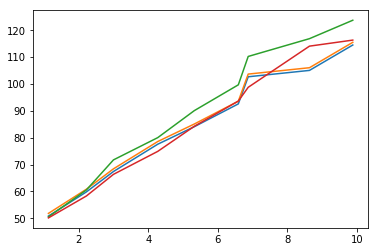

In [24]:
PISNSimulator = PISN_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return PISNSimulator.simulation(theta, seed)

simulator_args = None

theta_fiducial = np.array([Planck15.H0.value, Planck15.Om0, -1.0])

#plt.plot(PISNSimulator.aldata, PISNSimulator.data, '-k')
#s = np.random.randint(1<<32)
#plt.plot(PISNSimulator.aldata, simulator(theta_fiducial, s, None, 1))
s = np.random.randint(1<<32)
plt.plot(PISNSimulator.aldata, simulator(theta_fiducial, s, None, 1))
plt.plot(PISNSimulator.aldata, simulator(theta_fiducial, s, None, 1)+1)
plt.plot(PISNSimulator.aldata, simulator(theta_fiducial+np.array([0,0,0.5]), s, None, 1))
plt.plot(PISNSimulator.aldata, simulator(theta_fiducial+np.array([0,0,-0.5]), s, None, 1))

## Set up the prior

In [8]:
prior_low = np.array([35.0, 0.0, -2.0])
prior_high = np.array([140.0, 1.0, 0.0])

# Use these priors if you just want to measure w:
prior_C = np.diag([(0.01*theta_fiducial[0])**2, (0.01*theta_fiducial[1])**2, 0.5**2])

# Use these priors if you don't want to measure w, but want to just constrain cosmology:
#prior_C = np.diag([15**2, 0.15**2, 0.5**2, 10.0**2])

# Om = Planck15.Om0
# H0 = Planck15.H0.value
# h0 = Planck15.H0.value/100

# # Use this to include H0 Om covariance
# Covhomh2 = np.diag([(0.01*H0)**2, (0.01*Om*h0**2)**2])
# J = np.array([[1.0, 0.0], [2.0*Om*h0/100.0, h0**2]])# d(H0, Omh2)/d(H0, Om)
# Jinv = np.linalg.inv(J)
# Covhom = np.dot(Jinv.T, np.dot(Covhomh2, Jinv))

# # Parameter order is H0, Om, w, m90
# prior_C = np.diag([0.7**2, 0.**2, 0.5**2, 10.0**2])
# prior_C[0:2, 0:2] = Covhom

prior = priors.TruncatedGaussian(theta_fiducial, prior_C, prior_low, prior_high)

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

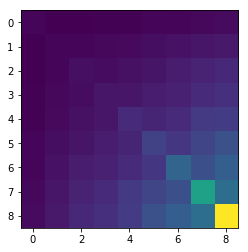

[[ 2.04883657e-01  1.38937636e-01  3.89714800e-01  4.37176002e-01
   2.72281122e-01  2.69930147e-01  7.79571886e-01  7.11113539e-01
   1.49326710e-01]
 [ 3.15012821e+01 -1.05721270e+01  2.33516980e+01  3.09824039e+01
   3.12280929e+00  5.39496711e+01  4.87175765e+01  2.19862921e+02
  -3.00036354e+01]
 [ 3.90951335e+00 -4.17201136e+00  6.33815485e+00 -5.08429741e+00
  -2.49272143e+00 -1.10884583e+01  1.59622283e+01  7.55201173e+00
  -7.01222934e-01]]


In [9]:
h = np.array(abs(theta_fiducial))*0.01

Compressor = score.Gaussian(len(PISNSimulator.data), theta_fiducial, prior_mean=theta_fiducial, prior_covariance=prior_C)
Compressor.compute_mean_covariance(simulator = simulator, nsims = 300)
Compressor.compute_derivatives(simulator = simulator, nsims = 300, h=h)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

plt.imshow(Compressor.C)
plt.show()

print(Compressor.dmudt)

In [10]:
# def dlofz(aldata, theta):

#     # Cosmological parameters
#     h0 = theta[0]
#     omegam = theta[1]
#     om = theta[2]
#     m90_0 = theta[3]

#     cosm = FlatwCDM(h0, omegam, om)
#     m90 = np.linspace(0,0,len(aldata))
#     for i in range(len(aldata)):
#         z = z_at_value(cosm.luminosity_distance, aldata[i]*u.Gpc)        
#     # Pull out the relevant things from the data
#         m90[i] = m90_0*(z + 1)

#     return m90

# plt.errorbar(PISNSimulator.aldata, dlofz(PISNSimulator.aldata,theta_fiducial), np.diag(np.sqrt(Compressor.C)), color='k')
# plt.errorbar(PISNSimulator.aldata, PISNSimulator.data, yerr = np.diag(np.sqrt(Compressor.C)))

In [11]:
np.sqrt(np.diag(Finv))

array([0.65455227, 0.00298671, 0.05529411])

In [12]:
evals, evecs = np.linalg.eigh(Compressor.Finv)

In [13]:
np.sqrt(evals), evecs

(array([0.00296532, 0.05469278, 0.65460289]),
 array([[-1.79077900e-04,  1.24779335e-02, -9.99922132e-01],
        [-9.99979349e-01, -6.42593000e-03,  9.88995753e-05],
        [-6.42419556e-03,  9.99901499e-01,  1.24788266e-02]]))

## Load in the compressed data

In [14]:
compressed_data = compressor(PISNSimulator.data, compressor_args)

## Define ensemble of NDEs

In [15]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [16]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [prior_low, prior_high],
                            param_names = ['h_0', 'Omega_0', 'omega'], 
                            results_dir = "results/",
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs


Sampling approximate posterior...
Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


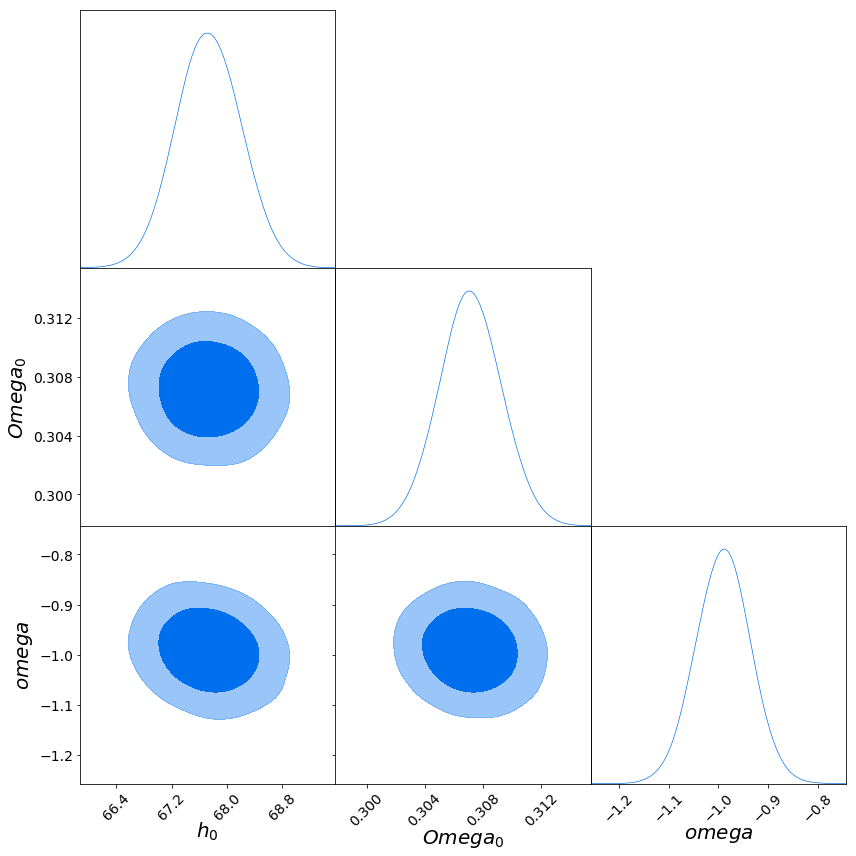

In [17]:
DelfiEnsemble.fisher_pretraining()

## Sequential Neural Likelihood


Population 1/10
Sampling proposal density...
Done.



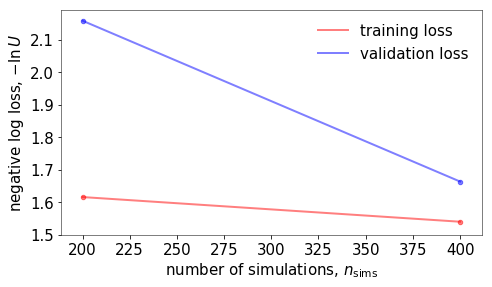

Population 2/10
Sampling proposal density...
34/|/ 11%|| 34/300 [00:30<02:54,  1.52it/s, train loss=1.34, val loss=1.47, refresh=1]Done.


21/|/  7%|| 21/300 [00:12<02:07,  2.18it/s, train loss=1.55, val loss=1.74, refresh=1]


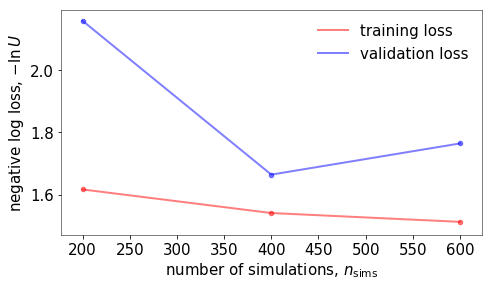

Population 3/10
Sampling proposal density...
24/|/  8%|| 24/300 [00:24<01:51,  2.48it/s, train loss=1.36, val loss=1.87, refresh=1]Done.


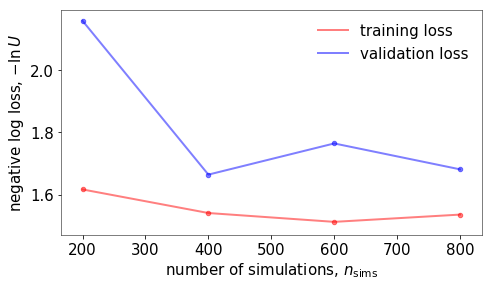

Population 4/10
Sampling proposal density...
29/|/ 10%|| 29/300 [00:21<01:44,  2.59it/s, train loss=1.37, val loss=1.97, refresh=1]Done.


21/|/  7%|| 21/300 [00:12<02:48,  1.66it/s, train loss=1.57, val loss=1.49, refresh=1]

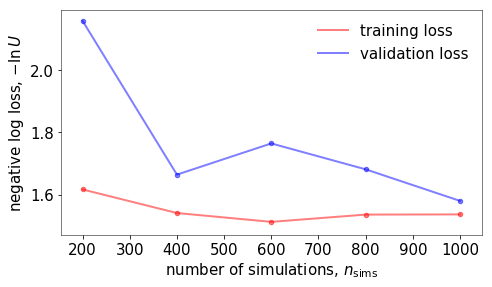

Population 5/10
Sampling proposal density...
22/|/  7%|| 22/300 [00:14<02:31,  1.84it/s, train loss=1.54, val loss=1.61, refresh=1]Done.


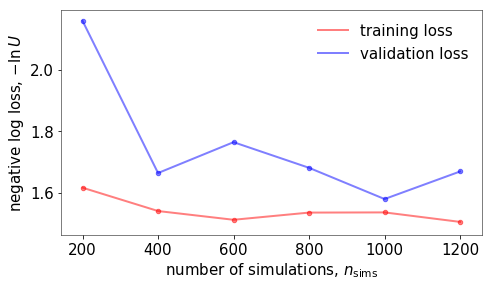

Population 6/10
Sampling proposal density...
23/|/  8%|| 23/300 [00:22<02:18,  2.00it/s, train loss=1.51, val loss=1.72, refresh=1]Done.


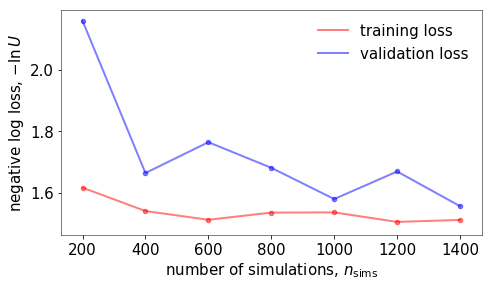

Population 7/10
Sampling proposal density...
21/|/  7%|| 21/300 [00:21<01:22,  3.39it/s, train loss=1.44, val loss=1.56, refresh=1]Done.


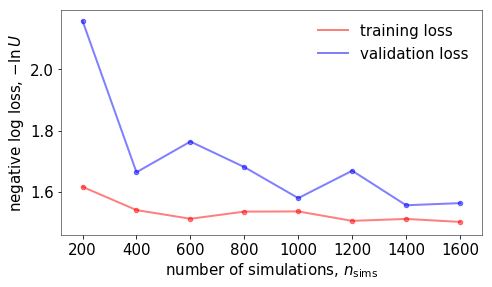

Population 8/10
Sampling proposal density...
22/|/  7%|| 22/300 [00:23<01:50,  2.51it/s, train loss=1.41, val loss=1.68, refresh=1]Done.


21/|/  7%|| 21/300 [00:14<02:59,  1.56it/s, train loss=1.55, val loss=1.49, refresh=1]


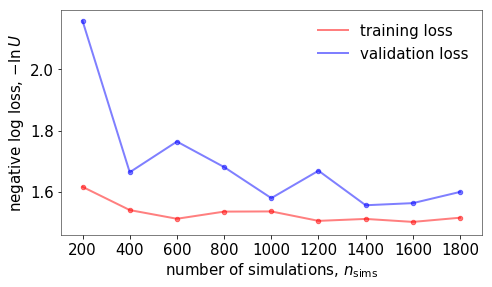

Population 9/10
Sampling proposal density...
22/|/  7%|| 22/300 [00:24<02:36,  1.77it/s, train loss=1.53, val loss=1.55, refresh=1]Done.


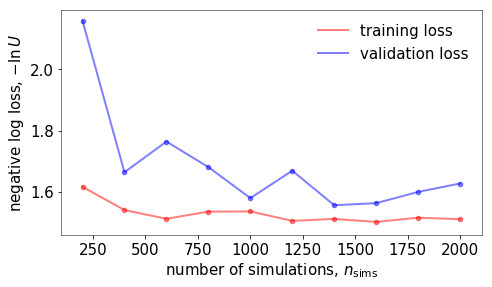

Population 10/10
Sampling proposal density...
24/|/  8%|| 24/300 [00:24<01:59,  2.31it/s, train loss=1.45, val loss=1.65, refresh=1]Done.


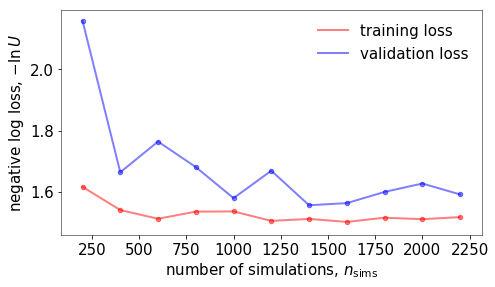

In [18]:
n_initial = 200
n_batch = 200
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=False)

## Sample the learned posterior

In [19]:
posterior_samples = DelfiEnsemble.emcee_sample()

25/|/  8%|| 25/300 [00:28<01:52,  2.44it/s, train loss=1.47, val loss=1.68, refresh=1]

/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


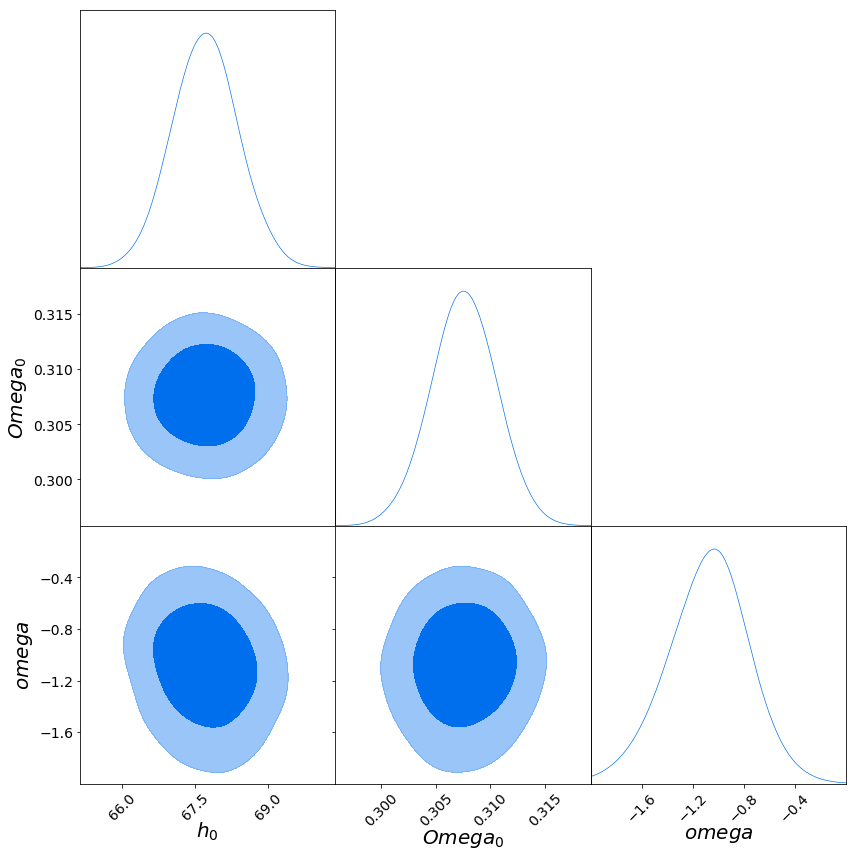

In [20]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])